In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_process(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.txt'

    return df

def load_process_cleaned(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}_clean.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}.txt'

    return df

process_path = './data/PROCESS-V1'
df = load_process(process_path)
df_clean = load_process_cleaned(process_path)

In [3]:
w2v2processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
w2v2model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base-960h')

def extract_wav2vec_features(wav_path):
    waveform, sample_rate = torchaudio.load(wav_path)
    inputs = w2v2processor(waveform.squeeze(), sampling_rate=sample_rate, return_tensors='pt', padding=True)
    with torch.no_grad():
        outputs = w2v2model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# df_train_w2v_ctd = [extract_wav2vec_features(a) for a in tqdm(df['CTD_wav'].values)]
# np.savetxt('./data/features/process-ctd-w2v-feature.csv', df_train_w2v_ctd, delimiter=',')
# df_train_w2v_pft = [extract_wav2vec_features(a) for a in tqdm(df['PFT_wav'].values)]
# np.savetxt('./data/features/process-pft-w2v-feature.csv', df_train_w2v_pft, delimiter=',')
# df_train_w2v_sft = [extract_wav2vec_features(a) for a in tqdm(df['SFT_wav'].values)]
# np.savetxt('./data/features/process-sft-w2v-feature.csv', df_train_w2v_sft, delimiter=',')

# df_train_w2v_ctd_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['CTD_wav'].values)]
# np.savetxt('./data/features/process-ctd-w2v-feature-clean.csv', df_train_w2v_ctd_clean, delimiter=',')
# df_train_w2v_pft_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['PFT_wav'].values)]
# np.savetxt('./data/features/process-pft-w2v-feature-clean.csv', df_train_w2v_pft_clean, delimiter=',')
# df_train_w2v_sft_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['SFT_wav'].values)]
# np.savetxt('./data/features/process-sft-w2v-feature-clean.csv', df_train_w2v_sft_clean, delimiter=',')

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
ctd_features = pd.read_csv("./data/features/process-ctd-w2v-feature.csv", header=None)
pft_features = pd.read_csv("./data/features/process-pft-w2v-feature.csv", header=None)
sft_features = pd.read_csv("./data/features/process-sft-w2v-feature.csv", header=None)
ctd_features_clean = pd.read_csv("./data/features/process-ctd-w2v-feature-clean.csv", header=None)
pft_features_clean = pd.read_csv("./data/features/process-pft-w2v-feature-clean.csv", header=None)
sft_features_clean = pd.read_csv("./data/features/process-sft-w2v-feature-clean.csv", header=None)

df['Converted-MMSE'] = df.groupby('Class')['Converted-MMSE'].transform(lambda x: x.fillna(x.mean()))
features = pd.concat([ctd_features_clean, pft_features_clean, sft_features_clean, df['Age']], axis=1, ignore_index=False)
X = features.to_numpy()
y_class, string_classes = pd.factorize(df['Class'])
y_reg = df["Converted-MMSE"]


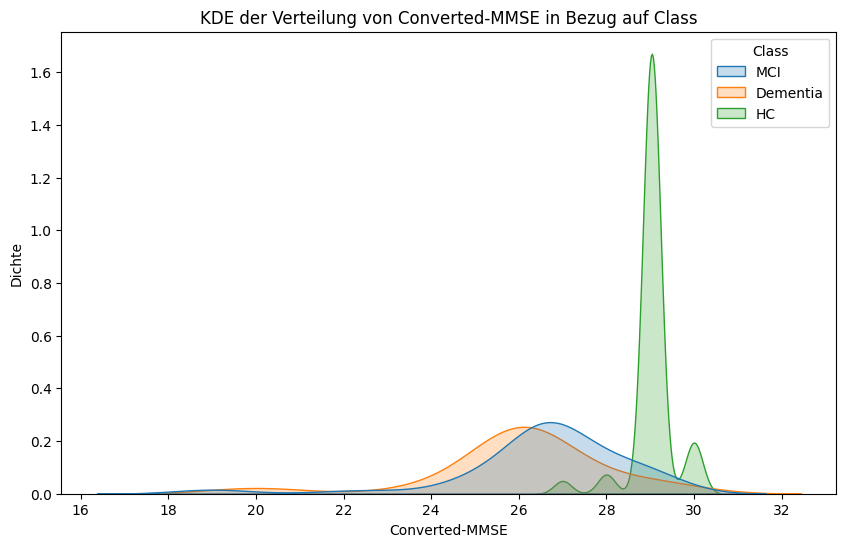

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE für "Converted-MMSE" in Bezug auf "Class"
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="Converted-MMSE", hue="Class", fill=True, common_norm=False)
plt.title('KDE der Verteilung von Converted-MMSE in Bezug auf Class')
plt.xlabel('Converted-MMSE')
plt.ylabel('Dichte')
plt.show()

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

param_grid_svm = {
    'C': [1, 10], 
    'gamma': [0.001, 0.01, 1],     
    }

grid_svm = GridSearchCV(SVC(kernel='linear', class_weight="balanced", random_state=42), param_grid_svm, cv=5, scoring="accuracy")
grid_svm.fit(X, y_class)

GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', kernel='linear',
                           random_state=42),
             param_grid={'C': [1, 10], 'gamma': [0.001, 0.01, 1]},
             scoring='accuracy')

In [7]:
svm_model = grid_svm.best_estimator_
rfe = RFECV(estimator=svm_model, step=1, cv=5, n_jobs=-1) 
X_rfe = rfe.fit_transform(X, y_class)

cv_scores = cross_val_score(svm_model, X_rfe, y_class, cv=5, scoring='accuracy')
svm_pred = cross_val_predict(svm_model, X_rfe, y_class, cv=5)

print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_class, svm_pred))
print("Classification Report:\n", classification_report(y_class, svm_pred))



Cross-Validation Accuracy (5-fold): [0.96875    0.875      0.70967742 0.87096774 0.83870968]
Durchschnittliche Genauigkeit: 0.8526209677419356
Accuracy: 0.8535031847133758
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        59
           1       0.67      0.38      0.48        16
           2       0.92      0.93      0.92        82

    accuracy                           0.85       157
   macro avg       0.79      0.73      0.75       157
weighted avg       0.85      0.85      0.85       157



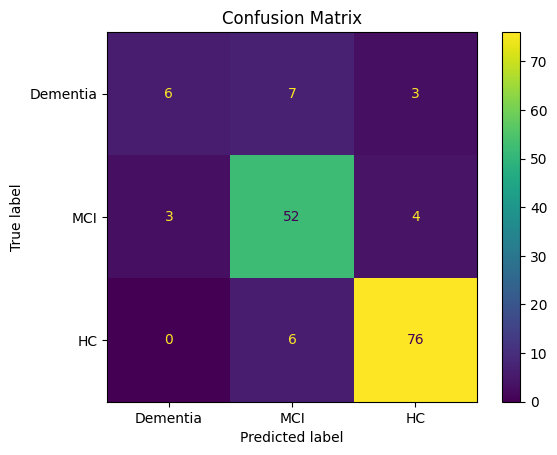

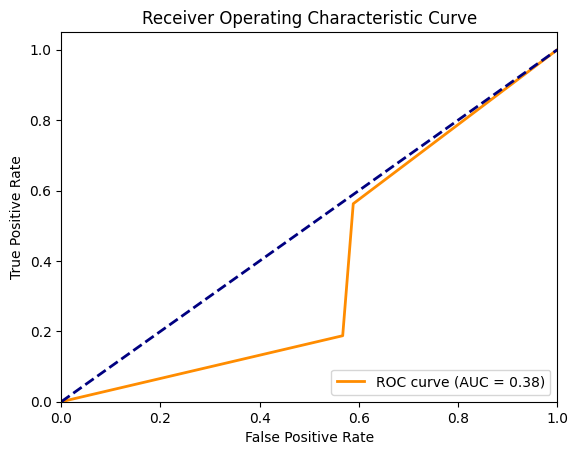

In [8]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

labels = ['Dementia', 'MCI', 'HC']
cm = confusion_matrix(y_class, svm_pred, labels=[1, 0, 2])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dementia", "MCI", "HC"]).plot()
cmd.ax_.set_title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_class, svm_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


Cross-Validation Scores: [-4.80600645 -3.3175184  -3.02891703 -2.20652227 -2.24108586]
Durchschnittlicher MSE: 3.120010001481009
Mean Squared Error: 3.1320068476366445
R2 Score: 0.14618564830566305


C:\Users\Christian\AppData\Local\Temp\ipykernel_9692\145309843.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], '--k', color='red')


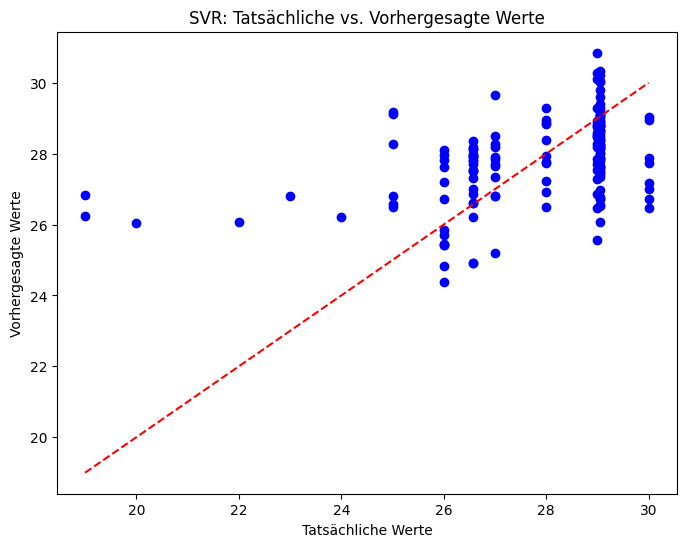

In [9]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

param_grid_svr = {
    'C': [1, 10], 
    'gamma': [0.001, 0.01, 1],     
    }
grid_svr = GridSearchCV(SVR(kernel='linear'), param_grid_svr, cv=5, scoring="neg_mean_squared_error")
grid_svr.fit(X, y_reg)
svr_model = grid_svr.best_estimator_
rfe = RFECV(estimator=svr_model, step=1, cv=5, n_jobs=-1) 
X_rfe = rfe.fit_transform(X, y_reg)

cv_scores = cross_val_score(svr_model, X, y_reg, cv=5, scoring="neg_mean_squared_error")
svr_pred = cross_val_predict(svr_model, X, y_reg, cv=5)

mse = mean_squared_error(y_reg, svr_pred)
r2 = r2_score(y_reg, svr_pred)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Durchschnittlicher MSE: {-cv_scores.mean()}")

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Optional: Visualisierung der tatsächlichen vs. vorhergesagten Werte
plt.figure(figsize=(8, 6))
plt.scatter(y_reg, svr_pred, color='blue')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], '--k', color='red')
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('SVR: Tatsächliche vs. Vorhergesagte Werte')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight="balanced"), param_grid=param_grid_rf, scoring='accuracy', cv=5, n_jobs=-1)
grid_rf.fit(X, y_class)

c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan na

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [11]:
from sklearn.model_selection import cross_val_score, cross_val_predict
rf_model = grid_rf.best_estimator_
rfe = RFECV(estimator=rf_model, step=1, cv=5, n_jobs=-1) 
X_rfe = rfe.fit_transform(X, y_class)

cv_scores = cross_val_score(rf_model, X_rfe, y_class, cv=5, scoring='accuracy')
rf_pred = cross_val_predict(rf_model, X_rfe, y_class, cv=5)



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Christian\AppData\Local\P

Cross-Validation Accuracy (5-fold): [nan nan nan nan nan]
Durchschnittliche Genauigkeit: nan
Accuracy: 0.535031847133758
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.42      0.42        59
           1       0.00      0.00      0.00        16
           2       0.61      0.72      0.66        82

    accuracy                           0.54       157
   macro avg       0.34      0.38      0.36       157
weighted avg       0.47      0.54      0.50       157



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

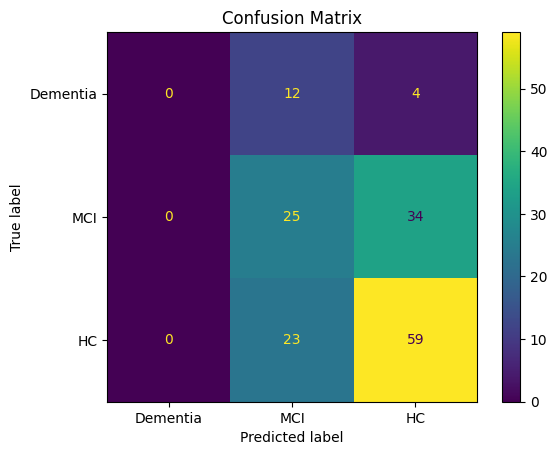

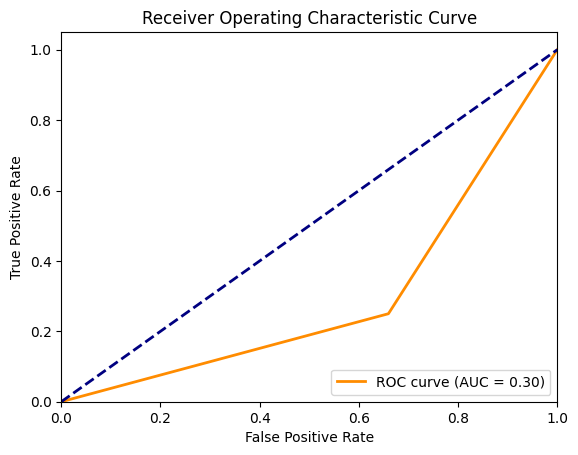

In [12]:
print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_class, rf_pred))
print("Classification Report:\n", classification_report(y_class, rf_pred))

labels = ['Dementia', 'MCI', 'HC']
cm = confusion_matrix(y_class, rf_pred, labels=[1, 0, 2])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dementia", "MCI", "HC"]).plot()
cmd.ax_.set_title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_class, rf_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV


param_grid_rf_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf_reg = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf_reg, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf_reg.fit(X, y_reg)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

Cross-Validation Scores: [-4.79816455 -3.63022078 -3.0830389  -2.07637034 -1.95000889]
Durchschnittlicher MSE: 3.1075606940727916
Cross-Validation Scores: [-4.79816455 -3.63022078 -3.0830389  -2.07637034 -1.95000889]
Durchschnittlicher MSE: 3.1075606940727916
Mean Squared Error: 3.1216579166670564
R2 Score: 0.14900686365300364


C:\Users\Christian\AppData\Local\Temp\ipykernel_9692\2587350645.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], '--k', color='red')


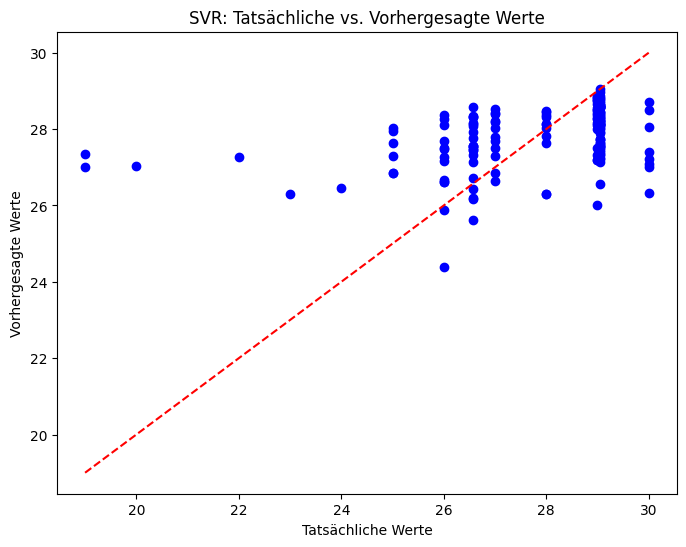

In [14]:

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

rf_reg = grid_rf_reg.best_estimator_
cv_scores = cross_val_score(rf_reg, X, y_reg, cv=5, scoring='neg_mean_squared_error')
rf_reg_pred = cross_val_predict(rf_reg, X, y_reg, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Durchschnittlicher MSE: {-cv_scores.mean()}")

mse = mean_squared_error(y_reg, rf_reg_pred)
r2 = r2_score(y_reg, rf_reg_pred)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Durchschnittlicher MSE: {-cv_scores.mean()}")

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Optional: Visualisierung der tatsächlichen vs. vorhergesagten Werte
plt.figure(figsize=(8, 6))
plt.scatter(y_reg, rf_reg_pred, color='blue')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], '--k', color='red')
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('SVR: Tatsächliche vs. Vorhergesagte Werte')
plt.show()


In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

param_grid_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid_gb, scoring='accuracy', cv=5, n_jobs=-1)
grid_gb.fit(X, y_class)

#GradientBoostingClassifier(min_samples_leaf=10, n_estimators=500,random_state=42)


KeyboardInterrupt: 

In [16]:
gb_model = GradientBoostingClassifier(min_samples_leaf=10, n_estimators=500, random_state=42)
#rfe = RFECV(estimator=gb_model, step=1, cv=5, n_jobs=-1) 
#X_rfe = rfe.fit_transform(X, y_class)

cv_scores = cross_val_score(gb_model, X, y_class, cv=5, scoring='accuracy')
gb_pred = cross_val_predict(gb_model, X, y_class, cv=5)

print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
print("Accuracy:", accuracy_score(y_class, gb_pred))
print("Classification Report:\n", classification_report(y_class, gb_pred))

KeyboardInterrupt: 

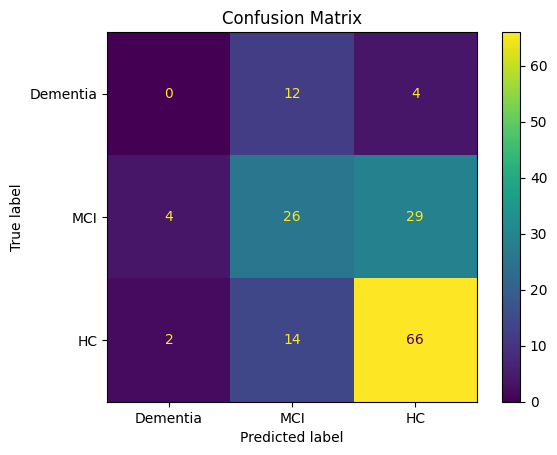

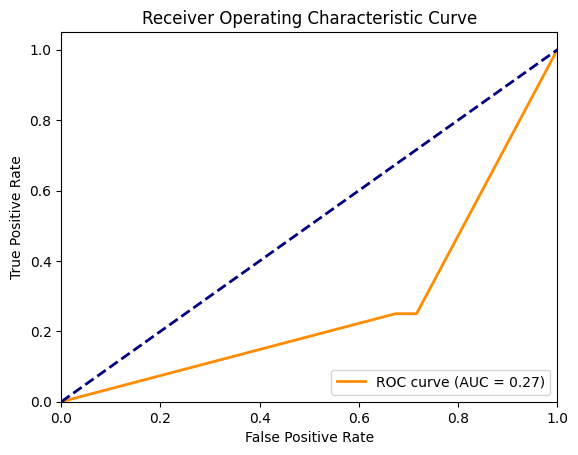

In [31]:
labels = ['Dementia', 'MCI', 'HC']
cm = confusion_matrix(y_class, gb_pred, labels=[1, 0, 2])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dementia", "MCI", "HC"]).plot()
cmd.ax_.set_title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_class, gb_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid=param_grid_xgb, scoring='accuracy', cv=5)
# grid_xgb.fit(X, y_class)


# from sklearn.feature_selection import RFECV
# from sklearn.metrics import classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.decomposition import PCA
# from xgboost import XGBClassifier

# xgb_model = XGBClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=5,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     random_state=42
# )

# rfe = RFECV(estimator=xgb_model, step=1, cv=5, n_jobs=-1) 
# X_rfe = rfe.fit_transform(X, y_class)

# cv_scores = cross_val_score(xgb_model, X_rfe, y_class, cv=5, scoring='accuracy')
# xgb_pred = cross_val_predict(xgb_model, X_rfe, y_class, cv=5)

# print(f"Cross-Validation Accuracy (5-fold): {cv_scores}")
# print(f"Durchschnittliche Genauigkeit: {cv_scores.mean()}")
# print("Accuracy:", accuracy_score(y_class, xgb_pred))
# print("Classification Report:\n", classification_report(y_class, xgb_pred))

# labels = ['Dementia', 'MCI', 'HC']
# cm = confusion_matrix(y_class, xgb_pred, labels=[1, 0, 2])
# cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dementia", "MCI", "HC"]).plot()
# cmd.ax_.set_title('Confusion Matrix')
# plt.show()

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np

# generate_spec = False
# if generate_spec:
#     def generate_mel_spectrogram(path):
#         for index, row in df.iterrows():
#             id = row['Record-ID']
#             y, sr = librosa.load(row['SFT_wav'], sr=16000)
#             mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#             log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

#             plt.figure(figsize=(10, 4))
#             librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
#             plt.colorbar(format='%+2.0f dB')
#             plt.title('Mel-Spectrogram')
#             plt.tight_layout()
#             plt.savefig(f"{path}/{id}/{id}_SFT_spec.png")
#             plt.close()
#     process_path = './data/PROCESS-V1'
#     generate_mel_spectrogram(process_path)


In [ ]:
#import os
# import pandas as pd

# def collect_spec_files(base_dir, ext):
#     data = []
#     for root, dirs, files in os.walk(base_dir):
#         for file in files:
#             if file.endswith(f"{ext}_spec.png"):
#                 full_path = os.path.join(root, file)
#                 data.append({f"{ext}_spec": full_path})
#     df = pd.DataFrame(data)
#     return df

# df_spec_ctd = collect_spec_files(process_path, "CTD")
# df_spec_pft = collect_spec_files(process_path, "PFT")
# df_spec_sft = collect_spec_files(process_path, "SFT")

# df_spec = pd.concat([df ,df_spec_ctd, df_spec_pft, df_spec_sft], axis=1)
# display(df_spec)

# from transformers import ViTFeatureExtractor, ViTForImageClassification

# model_name = "dhritic99/vit-base-brain-alzheimer-detection"
# feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
# model = ViTForImageClassification.from_pretrained(model_name)

# from PIL import Image
# import torch

# def predict_image(X, model, feature_extractor):
#     predictions = []
#     for file in X:
#         image = Image.open(file).convert("RGB")
#         inputs = feature_extractor(images=image, return_tensors="pt")

#         with torch.no_grad():
#             outputs = model(**inputs)
#             logits = outputs.logits
#             predicted_class = torch.argmax(logits, dim=-1)
        
#         predictions.append(predicted_class.item())
#     return predictions

# vit_pred = predict_image(df_spec['CTD_spec'], model, feature_extractor)
# y, string_classes = pd.factorize(df['Class'])

# print("Accuracy:", accuracy_score(y, vit_pred))
# print("Classification Report:\n", classification_report(y, vit_pred))
# cmd = ConfusionMatrixDisplay(confusion_matrix(y, vit_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
# cmd.ax_.set_title('Confusion matrix')
# plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, y_class, test_size=0.2, random_state=42)
# # X_train_clean, X_test_clean, _, _ = train_test_split(features_clean, y, test_size=0.2, random_state=42)
# # X_train_age, X_test_age, _, _ = train_test_split(features, y, test_size=0.2, random_state=42)

# X_tensor_train = torch.tensor(X_train.values, dtype=torch.float32)
# # X_tensor_train_clean = torch.tensor(X_train_clean.values, dtype=torch.float32)
# y_tensor_train = torch.tensor(y_train, dtype=torch.long)

In [ ]:
# dataset = TensorDataset(X_tensor_train, y_tensor_train)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# train_model = True

# class FCNN(nn.Module):
#     def __init__(self, input_dim, num_classes):
#         super(FCNN, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         return self.fc(x)

# if train_model:
#     fcnn_model = FCNN(input_dim=2304, num_classes=3)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(fcnn_model.parameters(), lr=0.001)

#     for epoch in range(1000):
#         for batch in dataloader:
#             X_batch, y_batch = batch
#             outputs = fcnn_model(X_batch)
#             loss = criterion(outputs, y_batch)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#     model_save_path = "./models/fcnn_model.pth"
#     torch.save(fcnn_model.state_dict(), model_save_path)

# X_tensor_test = torch.tensor(X_test.values , dtype=torch.float32)

# with torch.no_grad():
#     outputs = fcnn_model(X_tensor_test)

# _, fcnn_pred = torch.max(outputs, 1)

# print("Accuracy:", accuracy_score(y_test, fcnn_pred))
# print("Classification Report:\n", classification_report(y_test, fcnn_pred))
# cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, fcnn_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
# cmd.ax_.set_title('Confusion matrix')
# plt.show()
